# True Color RGB (RGB example using non-reprojected VIS channels)
This jupyter notebook shows how to make a sub-region plot of True color RGB composition. This is an example of RGB composition using non-reprojected VIS channels of GOES-16.

**Warning: if your RAM is less than 8GB it is recommended to work with a small domain.**

Import the GOES package.

In [1]:
import GOES

Set path and name of file that will be read.

In [2]:
path = '/home/joao/Downloads/GOES-16/ABI/'
C01_file = 'OR_ABI-L2-CMIPF-M6C01_G16_s20202361700213_e20202361709521_c20202361709598.nc'
C02_file = 'OR_ABI-L2-CMIPF-M6C02_G16_s20202361700213_e20202361709521_c20202361709597.nc'
C03_file = 'OR_ABI-L2-CMIPF-M6C03_G16_s20202361700213_e20202361709521_c20202361709599.nc'

Reads the file.

In [3]:
C01_ds = GOES.open_dataset(path+C01_file)
C02_ds = GOES.open_dataset(path+C02_file)
C03_ds = GOES.open_dataset(path+C03_file)

Set the map domain.

In [4]:
domain = [-90.0,-30.0,-60.0,15.0]

Gets image with the coordinates of center of their pixels.

In [5]:
C01, LonCen, LatCen = C01_ds.image('CMI', lonlat='center', domain=domain)

Gets the **pixels_limits** parameter of C01. This parameter will be used in the other channels to obtain an imagen with the same domain than C01.

In [6]:
domain_in_pixels = C01.pixels_limits

Creates a mask that identifies the nan values of C01. This mask will be used to obtain the image of channel 03.

In [7]:
import numpy as np
mask = np.where(np.isnan(C01.data)==True, True, False)

Gets the image of channel 03 with the same coverage area as channel 01.

In [8]:
C03, _, _ = C03_ds.image('CMI', lonlat='none', domain_in_pixels=domain_in_pixels, nan_mask=mask)

Because the spatial resolution of channel 02 is 0.5 km and channel 01 is 1.0 km, it is necessary to double the **domain_in_pixels** values to obtain an image of **channel 02** with the same coverage area as **channel 01**.

In [9]:
C02_domain_in_pixels = domain_in_pixels*2 + np.array([0,1,0,1])

Repeats each element of the mask two times to match with the image size of channel 02.

In [10]:
C02_mask = np.kron(mask, np.ones((2,2), dtype=mask.dtype))

Gets the image of channel 02 with the same coverage area as channel 01.

In [11]:
C02, _, _ = C02_ds.image('CMI', lonlat='none', domain_in_pixels=C02_domain_in_pixels, nan_mask=C02_mask)

Deletes **C02_domain_in_pixels** and **C02_mask**.

In [12]:
del C02_domain_in_pixels, C02_mask

Since the size of **C02** is twice the size of **C01**, it is necessary to reduce it by averaging groups of 4 pixels (2 on the y-axis and 2 on the x-axis).

In [13]:
nx, ny = 2, 2
ysize, xsize = C02.data.shape
C02.data = np.mean(C02.data.reshape((int(ysize/ny),ny,int(xsize/nx),nx)), axis=(1,3))

Gets information about data.

In [14]:
sat = C01_ds.attribute('platform_ID')
time = C01_ds.variable('time_bounds').data[0]

Defines the name of product.

In [15]:
product = 'True color RGB'

Calculates the cosine of zenith angle.

In [16]:
cosz = GOES.cosine_of_solar_zenith_angle(LonCen.data, LatCen.data, time)

Calculates the coordinates of corners of pixels.

In [17]:
LonCor, LatCor = GOES.calculate_corners(LonCen, LatCen)

Deletes the coordinates of centers of pixels since they will no longer be used.

In [18]:
del LonCen, LatCen

Makes the RGB composition.

In [19]:
# converts reflectance factor of channel 01, 02 and 03 to reflectance and save them as R, G and B
R = C02.data/cosz.data
G = C03.data/cosz.data
B = C01.data/cosz.data

# sets limits between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# perfoms a gamma correction
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# calculates the true green
G = 0.45*R + 0.1*G + 0.45*B
G = np.clip(G, 0, 1)

# stack channels
RGB = np.dstack((R, G, B)).astype(np.float16)

# reshape RGB to 1-D array
RGB = RGB.reshape((RGB.shape[0]*RGB.shape[1],RGB.shape[2]))

# ensures RGB data is between 0 and 1
RGB = np.clip(RGB, 0.0, 1.0, dtype=RGB.dtype)

# creates a simple array to make the plot with pcolormesh
mask = np.where(mask==True,np.nan, 1).astype(np.float16)

Deletes unnecessary data.

In [20]:
del C01, C02, C03, cosz, R, G, B

Creates plot.

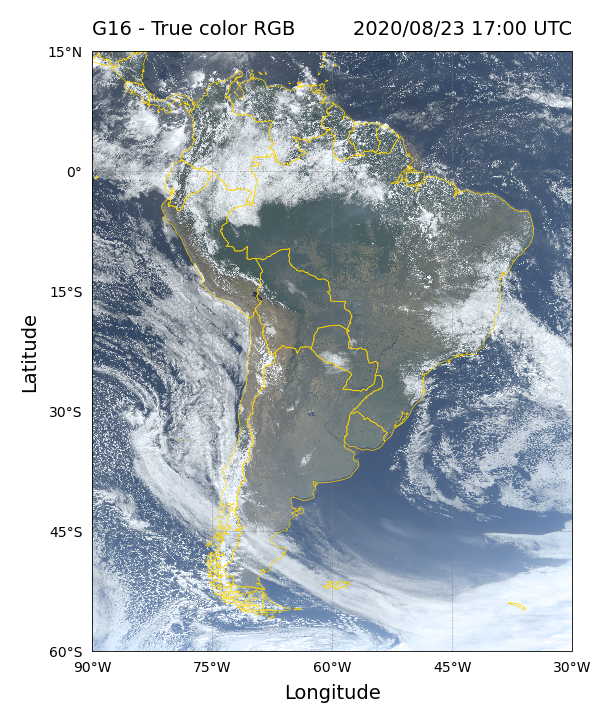

In [21]:
# import packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
#ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.25)

# plot the data
img = ax.pcolormesh(LonCor.data, LatCor.data, mask, transform=ccrs.PlateCarree(), color=RGB)

# set the title
ax.set_title('{} - {}'.format(sat, product), fontsize=7, loc='left')
ax.set_title(time.strftime('%Y/%m/%d %H:%M UTC'), fontsize=7, loc='right')

# Sets X axis characteristics
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)

# Sets Y axis characteristics
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)

# Sets tick characteristics
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')

# Sets grid characteristics
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()